In [17]:
# ------------------------------------------------------------------
# 0. Imports & paths
# ------------------------------------------------------------------
import math
import pandas as pd
from pathlib import Path
import numpy as np

RAW_CSV = Path("/home/rzby/ffmc_dc/data/raw/export-ME48-2015-01-01-2024-01-01.csv")           # adjust as needed
UTC_OFFSET = 8

In [9]:
# ------------------------------------------------------------------
# 1. Read raw file (timestamps are *UTC*)
# ------------------------------------------------------------------
df = pd.read_csv(RAW_CSV)

# --- identify the station column once
station_col = [c for c in df.columns if "WMO" in c.upper()][0]
df = df.rename(columns={station_col: "station_id"})

df["ts_utc"]      = pd.to_datetime(df["DATA TIMESTAMP"], utc=True)
df["ts_local"]    = df["ts_utc"] + pd.Timedelta(hours=8)          # UTC+8
df["local_hour"]  = df["ts_local"].dt.hour
df["date_local"]  = df["ts_local"].dt.floor("D")                  # local calendar day

# unit fix (knots  km h-1)
df["wind_kmh"] = df["WIND SPEED FF"] * 1.852

df.head()

/tmp/ipykernel_5060/2888850934.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ts_utc"]      = pd.to_datetime(df["DATA TIMESTAMP"], utc=True)


,station_id,DATA TIMESTAMP,EVAPORATION 24HOURS MM EEE,RAINFALL 24H RRRR,TEMP DRYBULB C TTTTTT,WIND SPEED FF,RELATIVE HUMIDITY PC,PRESSURE QFF MB DERIVED,ts_utc,ts_local,local_hour,date_local,wind_kmh
0,96595,2015-01-01 00:00:00.0 +0:00,7.0,7.6,23.4,0.0,98.3,1012.0,2015-01-01 00:00:00+00:00,2015-01-01 08:00:00+00:00,8,2015-01-01 00:00:00+00:00,0.0
1,96595,2015-01-01 01:00:00.0 +0:00,NaN,NaN,24.6,0.0,92.8,1012.2,2015-01-01 01:00:00+00:00,2015-01-01 09:00:00+00:00,9,2015-01-01 00:00:00+00:00,0.0
2,96595,2015-01-01 02:00:00.0 +0:00,NaN,NaN,27.0,0.0,80.8,1012.0,2015-01-01 02:00:00+00:00,2015-01-01 10:00:00+00:00,10,2015-01-01 00:00:00+00:00,0.0
3,96595,2015-01-01 03:00:00.0 +0:00,NaN,NaN,29.8,0.0,71.2,1011.0,2015-01-01 03:00:00+00:00,2015-01-01 11:00:00+00:00,11,2015-01-01 00:00:00+00:00,0.0
4,96595,2015-01-01 04:00:00.0 +0:00,NaN,NaN,30.7,0.0,65.4,1011.0,2015-01-01 04:00:00+00:00,2015-01-01 12:00:00+00:00,12,2015-01-01 00:00:00+00:00,0.0


#### Blok kode di bawah hanya untuk eksplorasi.

In [ ]:
def stratified_sample(df, stratify_col, n, random_state=None):
    """
    Take a stratified sample of n rows from a pandas DataFrame, 
    maintaining proportions of categories in the specified column.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        stratify_col (str): Column name to stratify by.
        n (int): Desired sample size (will be capped at len(df)).
        random_state (int, optional): Seed for reproducibility.

    Returns:
        pd.DataFrame: Sampled DataFrame with n rows.
    """
    n = min(n, len(df))
    if n == 0:
        return df.iloc[0:0].copy()
    
    groups = df.groupby(stratify_col, sort=False, group_keys=False)
    group_counts = groups.size()
    proportions = group_counts / group_counts.sum()
    target_float = n * proportions
    
    # Initial allocation (floor)
    target_per_group = np.floor(target_float).astype(int)
    remainder = n - target_per_group.sum()
    
    # Distribute remainder to groups with largest fractional parts
    fractional = target_float - target_per_group
    eligible_mask = target_per_group < group_counts
    eligible_groups = fractional[eligible_mask].sort_values(ascending=False)
    
    if remainder > 0 and not eligible_groups.empty:
        num_to_add = min(remainder, len(eligible_groups))
        groups_to_add = eligible_groups.head(num_to_add).index
        target_per_group[groups_to_add] += 1
    
    # Sample from each group
    samples = []
    for name, size in target_per_group.items():
        if size == 0:
            continue
        group_df = groups.get_group(name)
        samples.append(group_df.sample(n=min(size, len(group_df)), 
                          random_state=random_state))
    
    return pd.concat(samples, ignore_index=False)


In [ ]:
sampled_df = stratified_sample(data, 'WMO ID', n=100, random_state=21)
sampled_df

In [ ]:
sampled_df.to_csv('/home/rzby/ffmc_dc/src/sample_df.csv', index=False)

#### --- Dimulai lagi di sini ---

In [10]:
# Agregasi harian

def temp_13lt(group, window=2):
    sel = group[group["local_hour"].between(13-window, 13+window)]
    if sel.empty:
        return math.nan
    idx = (sel["local_hour"] - 13).abs().idxmin()
    return sel.at[idx, "TEMP DRYBULB C TTTTTT"]

daily_means = (
    df.groupby(["station_id", "date_local"], observed=True)
      .apply(lambda g: pd.Series({
          "temp_13LT_C"  : temp_13lt(g),
          "rh_avg_pc"    : g["RELATIVE HUMIDITY PC"].mean(),
          "wind_avg_kmh" : g["wind_kmh"].mean(),
          "qff_avg_hPa"  : g["PRESSURE QFF MB DERIVED"].mean(),
      }))
      .reset_index()
)


/tmp/ipykernel_5060/1865762600.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [12]:
# Pengelompokan data hujan dan penguapan

# Totals are logged at 00 UTC (08 LT) **for the previous day**.
tot_mask = df["ts_utc"].dt.hour == 0              # pick 00 UTC rows only
rain_evap = df.loc[tot_mask, ["station_id", "date_local",
                              "RAINFALL 24H RRRR",
                              "EVAPORATION 24HOURS MM EEE"]].copy()

# move them back one local day
rain_evap["date_local"] -= pd.Timedelta(days=1)

# keep the *last* record if two exist on the same date
daily_totals = (
    rain_evap.groupby(["station_id", "date_local"], observed=True)
             .agg(rain_mm = ("RAINFALL 24H RRRR", "last"),
                  evap_mm = ("EVAPORATION 24HOURS MM EEE", "last"))
             .reset_index()
)


In [13]:
daily = (
    daily_means
      .merge(daily_totals,
             on=["station_id", "date_local"],
             how="left")                  # rain/evap may be missing
      .sort_values(["station_id", "date_local"])
)

daily.groupby('station_id').head()

,station_id,date_local,temp_13LT_C,rh_avg_pc,wind_avg_kmh,qff_avg_hPa,rain_mm,evap_mm
0,96595,2015-01-01 00:00:00+00:00,32.2,71.393750,0.926000,1009.587500,3.0,4.0
1,96595,2015-01-02 00:00:00+00:00,30.0,79.087500,0.926000,1010.581250,NaN,3.0
2,96595,2015-01-03 00:00:00+00:00,31.1,79.300000,0.000000,1010.856250,0.0,3.0
3,96595,2015-01-04 00:00:00+00:00,30.9,76.875000,1.157500,1009.850000,20.5,6.0
4,96595,2015-01-05 00:00:00+00:00,29.2,85.487500,0.578750,1010.387500,10.8,6.0
3289,96645,2015-01-01 00:00:00+00:00,23.8,91.781250,8.912750,1009.656250,15.8,4.0
3290,96645,2015-01-02 00:00:00+00:00,29.4,91.104167,6.327667,1009.975000,0.4,4.0
3291,96645,2015-01-03 00:00:00+00:00,30.3,90.350000,5.115048,1010.100000,NaN,1.0
3292,96645,2015-01-04 00:00:00+00:00,31.4,92.300000,6.482000,1009.412500,14.2,3.0
3293,96645,2015-01-05 00:00:00+00:00,30.7,95.008333,3.174857,1009.412500,NaN,NaN


In [16]:
daily.loc[daily["evap_mm"]>100]

,station_id,date_local,temp_13LT_C,rh_avg_pc,wind_avg_kmh,qff_avg_hPa,rain_mm,evap_mm
9316,96651,2022-08-08 00:00:00+00:00,32.3,80.250000,5.401667,1009.100000,0.0,8888.0
11765,96653,2020-05-13 00:00:00+00:00,33.5,79.375000,5.093000,1010.043750,124.5,9999.0
15466,96655,2021-06-30 00:00:00+00:00,31.6,86.208333,5.633167,1011.066667,41.0,9999.0
15603,96655,2021-11-14 00:00:00+00:00,29.3,88.708333,5.478833,1010.762500,67.4,8888.0
15685,96655,2022-02-04 00:00:00+00:00,29.2,91.833333,4.861500,1008.370833,66.8,8888.0
15759,96655,2022-04-19 00:00:00+00:00,24.8,94.000000,8.256833,1009.350000,61.5,8888.0
15957,96655,2022-11-03 00:00:00+00:00,33.2,81.458333,6.867833,1009.037500,110.4,9999.0
16087,96655,2023-03-13 00:00:00+00:00,30.0,88.875000,4.244167,1009.087500,99.0,8888.0


In [18]:
daily.replace(to_replace={
    8888: 0.01,
    9999: np.nan
}, inplace=True)

In [22]:
# Calculate missing percentage per station_id for all columns
missing_pct = (
    daily.groupby('station_id')
    .apply(lambda x: x.isna().mean() * 100)
    .round(2)
)

# Display results sorted by station_id (descending)
display(missing_pct.sort_index(ascending=False))

/tmp/ipykernel_5060/3747427897.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.isna().mean() * 100)


,station_id,date_local,temp_13LT_C,rh_avg_pc,wind_avg_kmh,qff_avg_hPa,rain_mm,evap_mm
station_id,,,,,,,,
96655,0.0,0.0,0.03,0.0,0.0,0.0,23.17,4.99
96653,0.0,0.0,0.03,0.0,0.0,0.0,30.81,3.31
96651,0.0,0.0,0.03,0.0,0.0,0.0,29.37,4.90
96645,0.0,0.0,0.22,0.0,0.0,0.0,6.43,7.54
96595,0.0,0.0,0.03,0.0,0.0,0.0,7.42,3.31


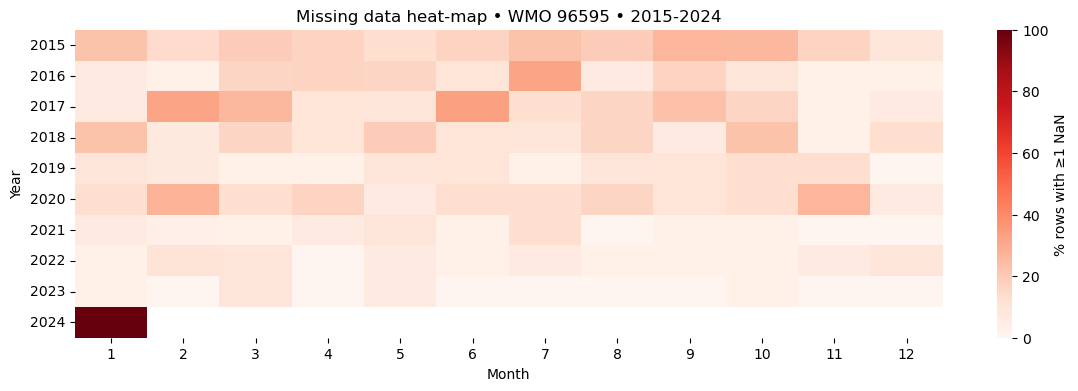

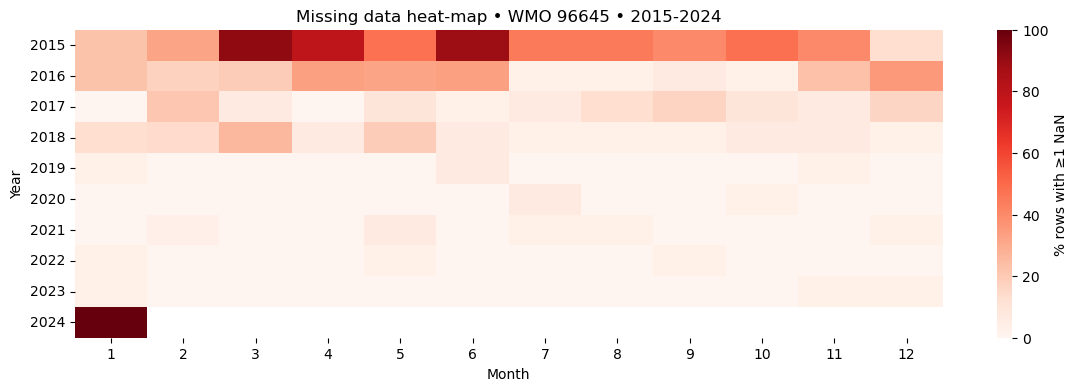

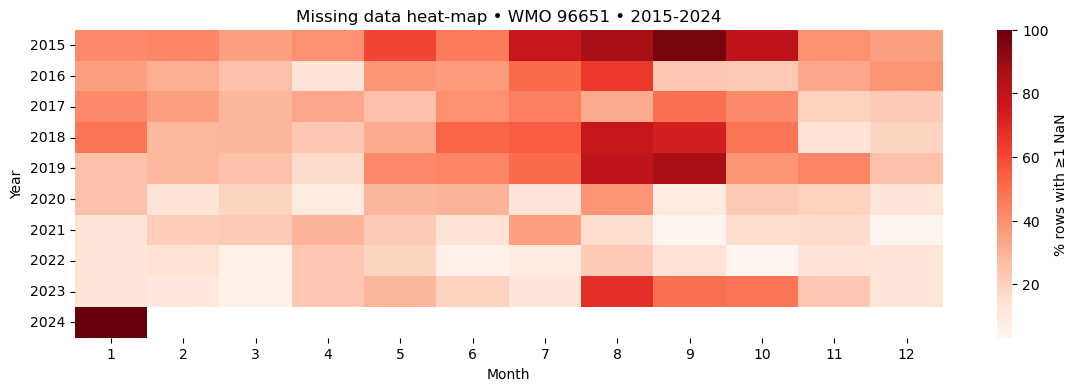

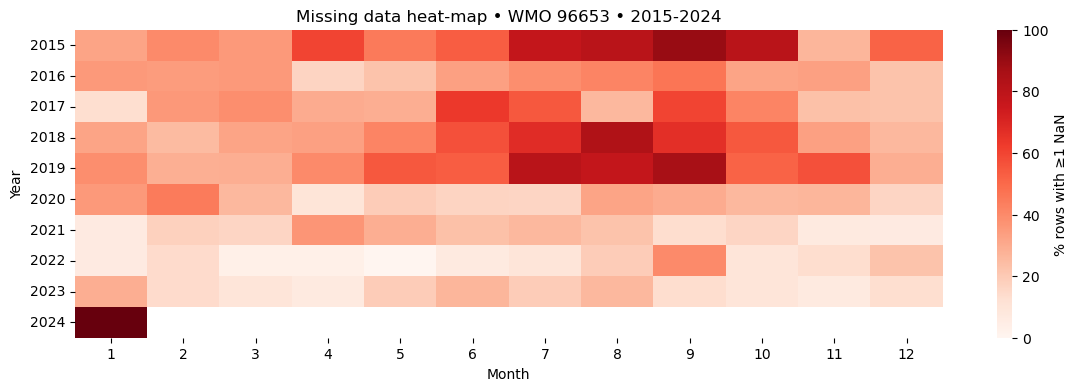

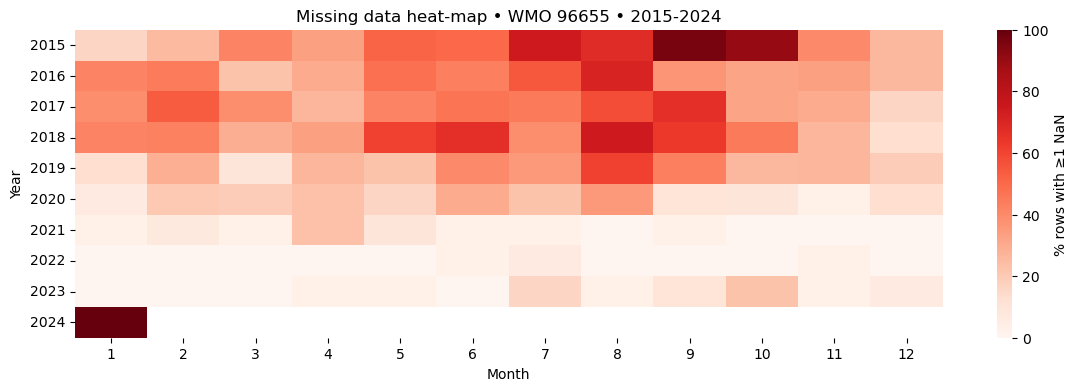

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Build a Y–M matrix of missing-row counts (any NaN in the row counts as missing)
for staid in daily["station_id"].unique():
    data_sta = daily.loc[daily["station_id"] == staid]
    mask_any_na = data_sta.isna().any(axis=1)
    miss_tbl = (
        mask_any_na.groupby([data_sta.date_local.dt.year, data_sta.date_local.dt.month])
        .mean()
        .unstack(level=1) * 100
        )
    
    plt.figure(figsize=(14,4))
    sns.heatmap(miss_tbl, cmap="Reds", cbar_kws={"label":"% rows with ≥1 NaN"})
    plt.title(f"Missing data heat-map • WMO {staid} • 2015-2024")
    plt.ylabel("Year")
    plt.xlabel("Month")
    plt.savefig(f"/home/rzby/ffmc_dc/reports/figures/missing_{staid}")
    plt.show()

In [24]:
# Month-wise gap-filling per station

daily["month"] = daily["date_local"].dt.month

# A. median-of-same-month for temp, RH, wind, QFF, evap
for col in ["temp_13LT_C", "rh_avg_pc",
            "wind_avg_kmh", "qff_avg_hPa", "evap_mm"]:
    daily[col] = (
        daily.groupby(["station_id", "month"])[col]
             .transform(lambda s: s.fillna(s.median()))
    )

# B. rainfall rule
other_cols = ["temp_13LT_C", "rh_avg_pc",
              "wind_avg_kmh", "qff_avg_hPa", "evap_mm"]

rain_na           = daily["rain_mm"].isna()
has_two_others    = daily.loc[rain_na, other_cols].notna().sum(axis=1) >= 2

# 1) ≥ 2 other values present  → 0 mm
daily.loc[rain_na & has_two_others, "rain_mm"] = 0

# 2) still NaN  → same-month median (per station)
daily["rain_mm"] = (
    daily.groupby(["station_id", "month"])["rain_mm"]
         .transform(lambda s: s.fillna(s.median()))
)

daily = daily.drop(columns="month")


In [26]:
daily.groupby("station_id").head()

,station_id,date_local,temp_13LT_C,rh_avg_pc,wind_avg_kmh,qff_avg_hPa,rain_mm,evap_mm
0,96595,2015-01-01 00:00:00+00:00,32.2,71.393750,0.926000,1009.587500,3.00,4.0
1,96595,2015-01-02 00:00:00+00:00,30.0,79.087500,0.926000,1010.581250,0.00,3.0
2,96595,2015-01-03 00:00:00+00:00,31.1,79.300000,0.000000,1010.856250,0.00,3.0
3,96595,2015-01-04 00:00:00+00:00,30.9,76.875000,1.157500,1009.850000,20.50,6.0
4,96595,2015-01-05 00:00:00+00:00,29.2,85.487500,0.578750,1010.387500,10.80,6.0
3289,96645,2015-01-01 00:00:00+00:00,23.8,91.781250,8.912750,1009.656250,15.80,4.0
3290,96645,2015-01-02 00:00:00+00:00,29.4,91.104167,6.327667,1009.975000,0.40,4.0
3291,96645,2015-01-03 00:00:00+00:00,30.3,90.350000,5.115048,1010.100000,0.00,1.0
3292,96645,2015-01-04 00:00:00+00:00,31.4,92.300000,6.482000,1009.412500,14.20,3.0
3293,96645,2015-01-05 00:00:00+00:00,30.7,95.008333,3.174857,1009.412500,0.00,4.0


In [27]:
# Calculate missing percentage per station_id for all columns
new_missing_pct = (
    daily.groupby('station_id')
    .apply(lambda x: x.isna().mean() * 100)
    .round(2)
)

# Display results sorted by station_id (descending)
display(new_missing_pct.sort_index(ascending=False))

/tmp/ipykernel_5060/980136072.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.isna().mean() * 100)


,station_id,date_local,temp_13LT_C,rh_avg_pc,wind_avg_kmh,qff_avg_hPa,rain_mm,evap_mm
station_id,,,,,,,,
96655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
out = Path("../data/processed/daily_features.parquet")
out.parent.mkdir(parents=True, exist_ok=True)
daily.to_parquet(out, index=False)